In [1]:
# Using a calval site get the RTC mean + sdev + delta.
# Additionally get the relevan values of dist-hls for the same pixel.
# Store everything on a table.
# Main plan:
# 1. Using the CalVal table choose a site
# 2. Get the corresponfing RTC. 
# 3. Calculate statistics using the VV and VH pol.
# 4. Using the same coordinates gather the DIST-HLS data. 
# 5. Store as a dataframe.

In [2]:
# libraries used in this notebook
import os
import math
import datetime
import geopandas as gpd
from dem_stitcher.geojson_io import read_geojson_gzip
import pandas as pd
# import folium
import leafmap
from tqdm import tqdm
import numpy as np
from osgeo import gdal
import rasterio as rio
import rioxarray
import xarray as xr
from pyproj import Transformer
import matplotlib.pyplot as plt

from netrc import netrc
from platform import system
from shapely.geometry import box
from pystac_client import Client 
from subprocess import Popen
from getpass import getpass 

from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon

### Take a look at the available data and choose a site to inspect

In [3]:
# Read burst summary table generated in dist-s1-research/marshak/4_rtc_organization/0_Organize-RTC-Data.ipynb
df_burst_summary = read_geojson_gzip('/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/marshak/4_rtc_organization/burst_extent_subset.geojson.zip')
df_burst_summary.head()

,geometry,jpl_burst_id,orbit_pass,count,is_val_burst,track_number
0,"POLYGON ((-97.90103 16.86358, -97.06559 17.014...",T005-008688-IW2,ASCENDING,66,False,5
1,"POLYGON ((-97.09889 17.06678, -96.35903 17.196...",T005-008688-IW3,ASCENDING,66,False,5
2,"POLYGON ((-98.69437 16.82087, -97.89903 16.966...",T005-008689-IW1,ASCENDING,66,False,5
3,"POLYGON ((-97.93485 17.03023, -97.09864 17.180...",T005-008689-IW2,ASCENDING,66,False,5
4,"POLYGON ((-97.13196 17.23328, -96.39139 17.362...",T005-008689-IW3,ASCENDING,66,False,5


In [4]:
# Read validation sites from table generated in dist-s1-research/marshak/3_dist_sites/dist_hls_validation_table.ipynb
df_val_sites = gpd.read_file('/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis/dist_hls_val_sites.geojson')
df_val_sites_subset = gpd.sjoin(df_val_sites, df_burst_summary[['jpl_burst_id', 'geometry']], predicate='intersects', how='inner').drop(columns=['index_right']).reset_index(drop=True)
df_val_sites_subset.head()

,site_id,change_label,change_time,last_observation_time,geometry,jpl_burst_id
0,4,VLmaj,2021-11-07,2021-11-02,POINT (19.33289 4.57490),T036-076228-IW3
1,13,VLmaj,2021-10-03,NaT,POINT (48.77698 31.75490),T108-230715-IW2
2,13,VLmaj,2021-10-03,NaT,POINT (48.77698 31.75490),T101-214979-IW1
3,22,VLmin,2021-12-19,2021-12-12,POINT (36.61178 35.52891),T014-028130-IW2
4,22,VLmin,2021-12-19,2021-12-12,POINT (36.61178 35.52891),T021-043823-IW2


In [5]:
# Read rtc information table generated in dist-s1-research/marshak/4_rtc_organization/0_Organize-RTC-Data.ipynb
df_rtc = pd.read_json('/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/marshak/4_rtc_organization/rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [6]:
# get the unique bursts ID's
track_numbers = df_burst_summary.track_number.unique()
len(track_numbers)

58

In [7]:
# Add track numbers if they are blocking tracks with data you require
TRACKS_TO_EXCLUDE = [137, 70]

gdf = df_burst_summary.copy()
gdf.geometry = df_burst_summary.geometry.exterior

def f(feature):
    return {
        'fillColor': 'yellow' if (feature['properties']['is_val_burst']) else 'blue',
        'weight': 2,
        'fillOpacity': 0.4 * float(feature['properties']['count']) / 100
    }

m = leafmap.Map()
m.add_gdf(df_burst_summary[~df_burst_summary.track_number.isin(TRACKS_TO_EXCLUDE)].copy(), 
          layer_name=f"Burst Data", info_mode='on_click', 
          style_callback=f)
m.add_gdf(df_val_sites_subset, 
      layer_name=f"Val. Sites", info_mode='on_click')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Choose site to inspect in the cell below. 
#### Provide the site ID number of choice. 

In [8]:
selected_site = 34

In [9]:
# Select a site and get the coordinates and RTC data
# Choosing Site 34 for testing
# Filtering the DataFrame
selected_val_site_df = df_val_sites_subset[df_val_sites_subset['site_id'] == selected_site]
print("~~~ Selected site:")
print(selected_val_site_df)
selected_site_change_time = selected_val_site_df['change_time'].values[0]
print("~~~ Change time:")
print(selected_site_change_time)
# Extracting the geometry where site_id is 72
selected_site_geo= selected_val_site_df['geometry'].values[0]
coordinates = (selected_site_geo.x, selected_site_geo.y) #lon, lat
print("~~~ Site coordinates:")
print(coordinates)
print("~~~ Corresponding Burst ID:")
BURST_ID = selected_val_site_df['jpl_burst_id'].values[0]
print(BURST_ID)
# get burst polygon
burst_summary = df_burst_summary[df_burst_summary['jpl_burst_id'] == BURST_ID] 
burst_poly = burst_summary['geometry'].values[0]

~~~ Selected site:
   site_id change_label change_time last_observation_time  \
7       34        VLmin  2021-10-22            2021-10-08   

                      geometry     jpl_burst_id  
7  POINT (-103.52487 20.04769)  T012-024584-IW1  
~~~ Change time:
2021-10-22
~~~ Site coordinates:
(-103.524865001448, 20.0476910292757)
~~~ Corresponding Burst ID:
T012-024584-IW1


In [10]:
# Get the RTC for the selected site and load to start analysis.
# Get all acquisitions for selected burst
df_burst_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)
print('Total dates for burst', BURST_ID, '=', len(df_burst_ts))
df_burst_ts.head()

Total dates for burst T012-024584-IW1 = 101


,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T012-024584-IW1_20201004T12500...,S1B_IW_SLC__1SDV_20201004T125000_20201004T1250...,T012-024584-IW1,30,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-04 12:50:00
1,OPERA_L2_RTC-S1_T012-024584-IW1_20201010T12504...,S1A_IW_SLC__1SDV_20201010T125027_20201010T1250...,T012-024584-IW1,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 12:50:27
2,OPERA_L2_RTC-S1_T012-024584-IW1_20201016T12500...,S1B_IW_SLC__1SDV_20201016T125000_20201016T1250...,T012-024584-IW1,30,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-16 12:50:00
3,OPERA_L2_RTC-S1_T012-024584-IW1_20201022T12504...,S1A_IW_SLC__1SDV_20201022T125027_20201022T1250...,T012-024584-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 12:50:27
4,OPERA_L2_RTC-S1_T012-024584-IW1_20201028T12500...,S1B_IW_SLC__1SDV_20201028T125001_20201028T1250...,T012-024584-IW1,30,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-28 12:50:01


In [11]:
# Get selected RTC EPSG
def get_epsg(file_path):
    with rio.open(file_path) as dataset:
        crs = dataset.crs
        if crs.is_epsg_code:
            return crs.to_epsg()
        else:
            return None
        
file_path = df_burst_ts.iloc[0]['rtc_s1_vv_url']
epsg_code = get_epsg(file_path)
print(f'The EPSG code of the image is: {epsg_code}')

The EPSG code of the image is: 32613


In [12]:
polarizations = ['vv', 'vh']
da_stack = []

# Define the longitude and latitude of the pixel to load
lon, lat = coordinates[0], coordinates[1]

# Initialize a transformer to convert lon/lat to the image's coordinate system
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_code}", always_xy=True)

# Transform the lon/lat to the target coordinate system
x, y = transformer.transform(lon, lat)

for t, row in df_burst_ts.iterrows():
    rtc_id = row['rtc_s1_id']
    time = pd.to_datetime(row['acq_datetime'])
    polarization_stack = []

    for polarization in polarizations:
        file_path = row[f"rtc_s1_{polarization}_url"]
     
        # Open the file and query the specific pixel value
        with rioxarray.open_rasterio(file_path) as da:
            # Select the pixel using the transformed coordinates
            da_pixel = da.sel(x=x, y=y, method="nearest") # bilinear | nearest 
            da_pixel = da_pixel.expand_dims(time=pd.Index([time], name='time'))
            polarization_stack.append(da_pixel)

    da_polarized = xr.concat(polarization_stack, dim=pd.Index(polarizations, name='polarization'))
    da_stack.append(da_polarized)

ds = xr.concat(da_stack, dim='time')
ds

<xarray.DataArray (polarization: 2, time: 101, band: 1)> Size: 808B
array([[[0.28424114],
        [0.15264525],
        [0.17369157],
        [0.21037292],
        [0.16708381],
        [0.16049469],
        [0.10310065],
        [0.21304241],
        [0.11229932],
        [0.17276417],
        [0.13373555],
        [0.09038806],
        [0.0932186 ],
        [0.07424495],
        [0.04163363],
        [0.04693648],
        [0.05364312],
        [0.04178704],
        [0.03437162],
        [0.06917804],
...
        [0.01491485],
        [0.0093433 ],
        [0.00665102],
        [0.00987993],
        [0.00955181],
        [0.01266534],
        [0.02003386],
        [0.02223788],
        [0.00968062],
        [0.01102261],
        [0.00736062],
        [0.00876378],
        [0.02208753],
        [0.01265381],
        [0.02316106],
        [0.01563395],
        [0.02508201],
        [0.00903187],
        [0.01006284],
        [0.005306  ]]], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 808B 2020-10-04T12:50:00 ... 2022-11-...
  * band          (band) int64 8B 1
    x             float64 8B 6.543e+05
    y             float64 8B 2.217e+06
    spatial_ref   int64 8B 0
  * polarization  (polarization) object 16B 'vv' 'vh'
Attributes: (12/87)
    ABSOLUTE_ORBIT_NUMBER:                                                   ...
    ACQUISITION_MODE:                                                        ...
    AREA_OR_POINT:                                                           ...
    BOUNDING_BOX:                                                            ...
    BOUNDING_BOX_EPSG_CODE:                                                  ...
    BOUNDING_BOX_PIXEL_COORDINATE_CONVENTION:                                ...
    ...                                                                         ...
    ZERO_DOPPLER_END_TIME:                                                   ...
    ZERO_DOPPLER_START_TIME:                                                 ...
    _FillValue:                                                              ...
    scale_factor:                                                            ...
    add_offset:                                                              ...
    long_name:                                                               ...

In [13]:
selected_site_change_time

'2021-10-22'

Plotting overview:


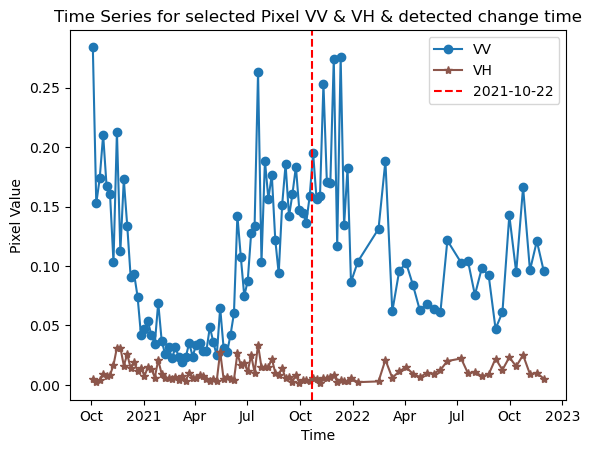

In [14]:
# Plot pixel TS
print("Plotting overview:")
# add change time to plot
# selected_site_change_time

pixel_ts_vv = ds.sel(polarization='vv')
pixel_ts_vh = ds.sel(polarization='vh') 
# Plotting the time series
pixel_ts_vv.plot(marker='o', color='tab:blue', linestyle='-', label='VV')
pixel_ts_vh.plot(marker='*', color='tab:brown', linestyle='-', label='VH')
vertical_line_date = pd.to_datetime('2021-10-22')
plt.axvline(x=vertical_line_date, color='r', linestyle='--', label=selected_site_change_time)
plt.title('Time Series for selected Pixel VV & VH & detected change time')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pixel Value')
plt.show()

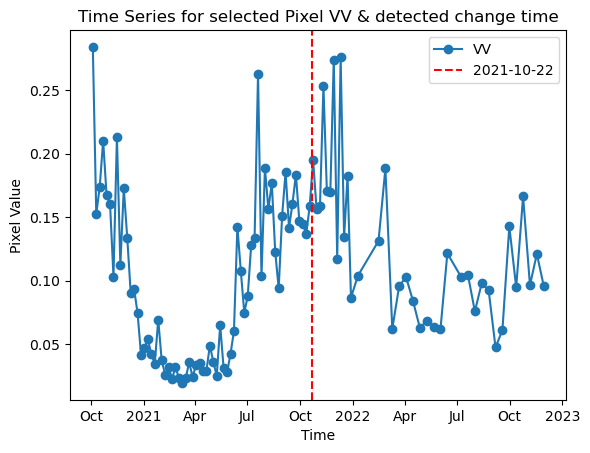

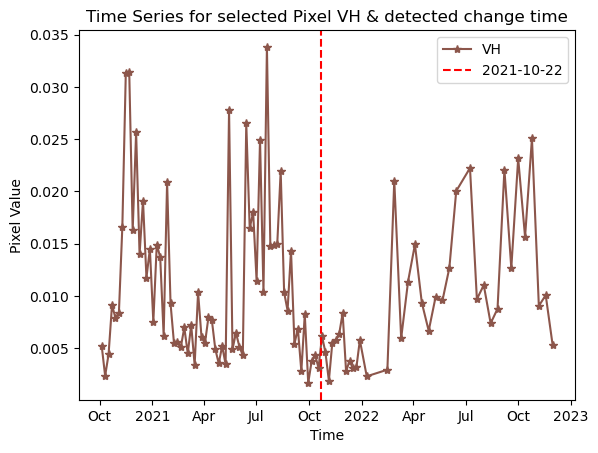

In [15]:
# Plotting the time series
pixel_ts_vv.plot(marker='o', color='tab:blue', linestyle='-', label='VV')
plt.axvline(x=vertical_line_date, color='r', linestyle='--', label=selected_site_change_time)
plt.title('Time Series for selected Pixel VV & detected change time')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pixel Value')
plt.show()

# Plotting the time series
pixel_ts_vh.plot(marker='*', color='tab:brown', linestyle='-', label='VH')
plt.axvline(x=vertical_line_date, color='r', linestyle='--', label=selected_site_change_time)
plt.title('Time Series for selected Pixel VH & detected change time')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pixel Value')
plt.show()

In [16]:
# Get available dates
dates = pixel_ts_vv['time'].values
# Convert the dates to 'YYYY-MM-DD' format
formatted_dates = [str(datetime.datetime.utcfromtimestamp(date.astype('O')/1e9).date()) for date in dates]
print(formatted_dates)

['2020-10-04', '2020-10-10', '2020-10-16', '2020-10-22', '2020-10-28', '2020-11-03', '2020-11-09', '2020-11-15', '2020-11-21', '2020-11-27', '2020-12-03', '2020-12-09', '2020-12-15', '2020-12-21', '2020-12-27', '2021-01-02', '2021-01-08', '2021-01-14', '2021-01-20', '2021-01-26', '2021-02-01', '2021-02-07', '2021-02-13', '2021-02-19', '2021-02-25', '2021-03-03', '2021-03-09', '2021-03-15', '2021-03-21', '2021-03-27', '2021-04-02', '2021-04-08', '2021-04-14', '2021-04-20', '2021-04-26', '2021-05-02', '2021-05-08', '2021-05-14', '2021-05-20', '2021-05-26', '2021-06-01', '2021-06-07', '2021-06-13', '2021-06-19', '2021-06-25', '2021-07-01', '2021-07-07', '2021-07-13', '2021-07-19', '2021-07-25', '2021-07-31', '2021-08-06', '2021-08-12', '2021-08-18', '2021-08-24', '2021-08-30', '2021-09-05', '2021-09-11', '2021-09-17', '2021-09-23', '2021-09-29', '2021-10-05', '2021-10-11', '2021-10-17', '2021-10-23', '2021-10-29', '2021-11-04', '2021-11-10', '2021-11-16', '2021-11-22', '2021-11-28', '2021

In [17]:
# Distance from the mean for a selected datetime
def dist_from_mean(pixel_ts, starttime=None, endtime=None, selectedtime='2022-10-01'):
    mean = pixel_ts.sel(time=slice(starttime, endtime)).mean(dim='time')
    sdev = pixel_ts.sel(time=slice(starttime, endtime)).std(dim='time') 
    selected_value = pixel_ts.sel(time=selectedtime).item() 
    delta = abs(mean.item() - pixel_ts.sel(time=selectedtime).item())

    print("Baseline Mean:", mean.item())
    print("Baseline Sdev:", sdev.item())
    print(f"Backscatter value for date {selectedtime}:", selected_value)
    print(f"Distance from the mean for date {selectedtime}:", delta)

    return delta

print("~~~ Basic VV stats ~~~")
mean_delta_vv = dist_from_mean(pixel_ts_vv, starttime=None, endtime='2022-10-01', selectedtime='2022-11-05') 
print("~~~ Basic VH stats ~~~")
mean_delta_vh = dist_from_mean(pixel_ts_vh, starttime=None, endtime='2022-10-01', selectedtime='2022-11-05') 

~~~ Basic VV stats ~~~
Baseline Mean: 0.10824640840291977
Baseline Sdev: 0.06576564162969589
Backscatter value for date 2022-11-05: 0.09633789211511612
Distance from the mean for date 2022-11-05: 0.01190851628780365
~~~ Basic VH stats ~~~
Baseline Mean: 0.010515443980693817
Baseline Sdev: 0.007439017295837402
Backscatter value for date 2022-11-05: 0.009031868539750576
Distance from the mean for date 2022-11-05: 0.0014835754409432411


### Read the Dist-Alert sample table for the chosen site

In [18]:
# Get sample from posted samples on github
dist_alert_sample_link = f"https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/mapLabelsv1sample/{selected_site}_DIST-ALERT_v1sample.csv"
# read to a geodataframe
dist_alert_sampl_df = pd.read_csv(dist_alert_sample_link)
dist_alert_sampl_df

,granuleID,SensingTime,ProductionTime,VEG-DIST-STATUS,VEG-ANOM,VEG-IND,VEG-HIST,VEG-ANOM-MAX,VEG-DIST-CONF,VEG-DIST-DATE,...,VEG-DIST-DUR,VEG-LAST-DATE,GEN-DIST-STATUS,GEN-ANOM,GEN-ANOM-MAX,GEN-DIST-CONF,GEN-DIST-DATE,GEN-DIST-COUNT,GEN-DIST-DUR,GEN-LAST-DATE
0,OPERA_L3_DIST-ALERT-HLS_T13QFC_20211004T172059...,20211004,2023-11-01 12:04:41,255,255,255,255,255,-1,NaN,...,-1,-1,255,-1,-1,-1,NaN,255,-1,-1
1,OPERA_L3_DIST-ALERT-HLS_T13QFC_20211006T171832...,20211006,2023-11-01 12:06:02,1,14,2,16,14,14,20211006.0,...,1,279,255,-1,-1,-1,NaN,255,-1,-1
2,OPERA_L3_DIST-ALERT-HLS_T13QFC_20211009T172231...,20211009,2023-11-01 12:07:13,1,255,255,16,14,14,20211006.0,...,1,279,255,-1,-1,-1,NaN,255,-1,-1
3,OPERA_L3_DIST-ALERT-HLS_T13QFC_20211013T172445...,20211013,2023-11-01 12:08:28,1,255,255,16,14,14,20211006.0,...,1,279,255,-1,-1,-1,NaN,255,-1,-1
4,OPERA_L3_DIST-ALERT-HLS_T13QFC_20211014T172259...,20211014,2023-11-01 12:09:24,1,255,255,16,14,14,20211006.0,...,1,279,255,-1,-1,-1,NaN,255,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,OPERA_L3_DIST-ALERT-HLS_T13QFC_20220922T172440...,20220922,2023-11-01 14:47:59,7,255,255,21,19,2079,20211006.0,...,81,622,0,-1,0,0,NaN,0,0,622
144,OPERA_L3_DIST-ALERT-HLS_T13QFC_20220923T171848...,20220923,2023-11-01 14:49:10,7,0,40,21,19,2079,20211006.0,...,81,631,0,1,0,0,NaN,0,0,631
145,OPERA_L3_DIST-ALERT-HLS_T13QFC_20220924T172051...,20220924,2023-11-01 14:50:36,7,0,56,21,19,2079,20211006.0,...,81,632,0,1,0,0,NaN,0,0,632
146,OPERA_L3_DIST-ALERT-HLS_T13QFC_20220929T172119...,20220929,2023-11-01 14:51:41,7,0,49,21,19,2079,20211006.0,...,81,637,0,9,0,0,NaN,0,0,637


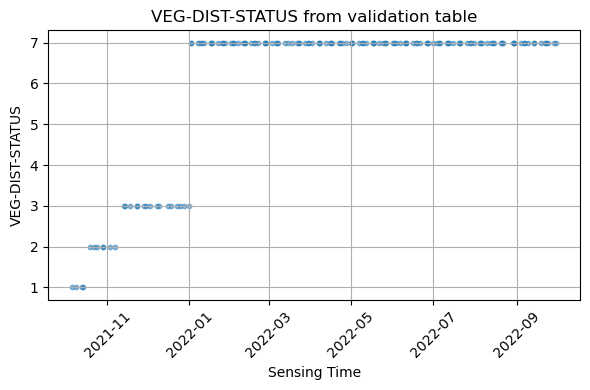

In [19]:
dist_alert_sampl_df['SensingTime'] = pd.to_datetime(dist_alert_sampl_df['SensingTime'], format='%Y%m%d')
# Filter out rows where 'VEG-DIST-STATUS' is 255
filtered_dist_alert_sampl_df = dist_alert_sampl_df[dist_alert_sampl_df['VEG-DIST-STATUS'] != 255]
# Create the scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(filtered_dist_alert_sampl_df['SensingTime'], filtered_dist_alert_sampl_df['VEG-DIST-STATUS'], s=10, alpha=0.5)
plt.title('VEG-DIST-STATUS from validation table')
plt.xlabel('Sensing Time')
plt.ylabel('VEG-DIST-STATUS')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

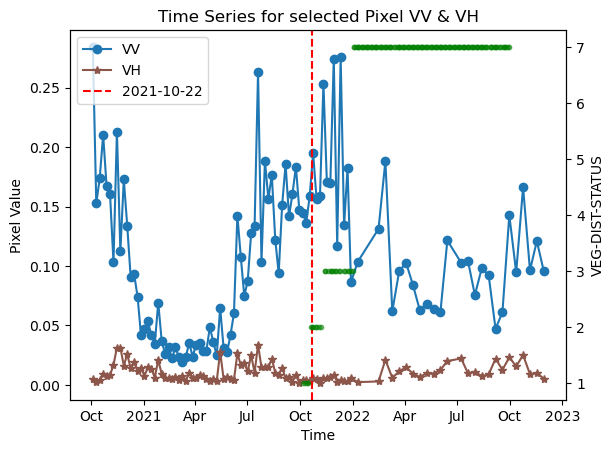

In [20]:
fig, ax1 = plt.subplots()
pixel_ts_vv.plot(marker='o', color='tab:blue', linestyle='-', label='VV', ax=ax1)
pixel_ts_vh.plot(marker='*', color='tab:brown', linestyle='-', label='VH', ax=ax1)
vertical_line_date = pd.to_datetime('2021-10-22')
ax1.axvline(x=vertical_line_date, color='r', linestyle='--', label=selected_site_change_time)
ax1.set_title('Time Series for selected Pixel VV & VH')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pixel Value')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.scatter(filtered_dist_alert_sampl_df['SensingTime'], filtered_dist_alert_sampl_df['VEG-DIST-STATUS'], s=10, alpha=0.5, color='g')
ax2.set_ylabel('VEG-DIST-STATUS')
plt.show()

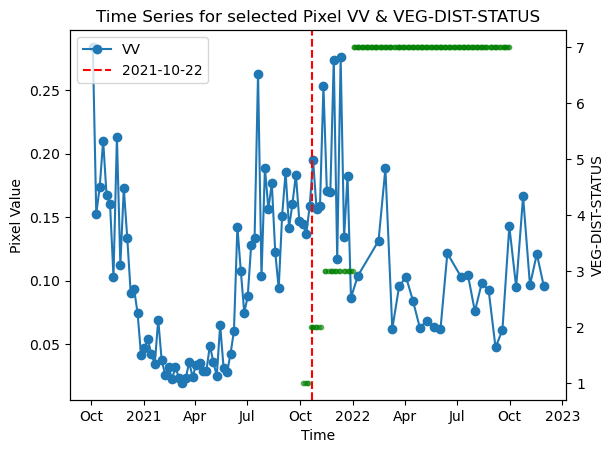

In [21]:
fig, ax1 = plt.subplots()
pixel_ts_vv.plot(marker='o', linestyle='-', label='VV', ax=ax1)
ax1.axvline(x=vertical_line_date, color='r', linestyle='--', label=selected_site_change_time)
ax1.set_title(f'Time Series for selected Pixel VV & VEG-DIST-STATUS')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pixel Value')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.scatter(filtered_dist_alert_sampl_df['SensingTime'], filtered_dist_alert_sampl_df['VEG-DIST-STATUS'], s=10, alpha=0.5, color='g')
ax2.set_ylabel('VEG-DIST-STATUS')
plt.show()

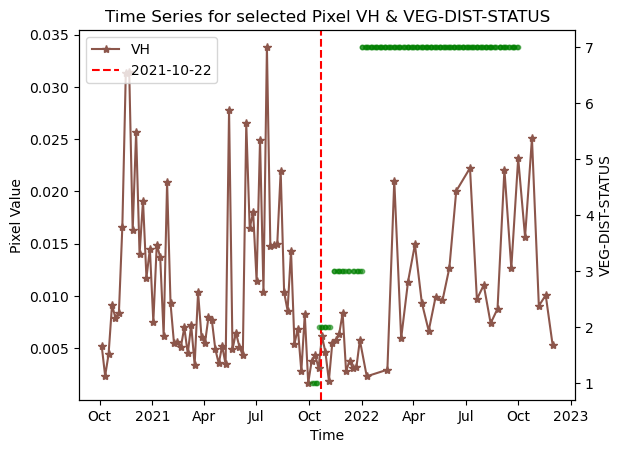

In [22]:
fig, ax1 = plt.subplots()
pixel_ts_vh.plot(marker='*', color='tab:brown', linestyle='-', label='VH', ax=ax1)
ax1.axvline(x=vertical_line_date, color='r', linestyle='--', label=selected_site_change_time)
ax1.set_title(f'Time Series for selected Pixel VH & VEG-DIST-STATUS')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pixel Value')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.scatter(filtered_dist_alert_sampl_df['SensingTime'], filtered_dist_alert_sampl_df['VEG-DIST-STATUS'], s=10, alpha=0.5, color='g')
ax2.set_ylabel('VEG-DIST-STATUS')
plt.show()

### Example on how to extract the Dist-HLS data from earthdata.
#### --> An earthdata.nasa.gov account is needed.
This section will use the boundaries of the burst matching the selected site and find the overlapping DIST-HLS data for a defined window of time.

In [23]:
# Authentication token
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

# Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

In [24]:
def get_box(center_coord):
    center_lon, center_lat = center_coord[0], center_coord[1]

    # Earth radius in kilometers
    earth_radius_km = 6371.0

    # Convert 5km to degrees latitude and longitude
    # Latitude: 1 degree is approximately 111.32 kilometers
    lat_diff_km = 5.0 / 111.32
    # Longitude: 1 degree varies with latitude, but for small distances, we can approximate it as constant
    # We can use the center latitude to calculate the approximate conversion
    lon_diff_km = (5.0 / (111.32 * math.cos(math.radians(center_lat))))

    # Calculate the corner coordinates
    top_left = (center_lon - lon_diff_km, center_lat + lat_diff_km)
    bottom_right = (center_lon + lon_diff_km, center_lat - lat_diff_km)

    print("Top Left Corner Coordinate:", top_left)
    print("Bottom Right Corner Coordinate:", bottom_right)

    return top_left, bottom_right

top_cords, bottom_cords = get_box(coordinates)

Top Left Corner Coordinate: (-103.57267764240791, 20.09260658802525)
Bottom Right Corner Coordinate: (-103.4770523604881, 20.00277547052615)


In [25]:
# search parameters
# aoi = box(top_cords[0], bottom_cords[1], bottom_cords[0], top_cords[1])
aoi = burst_poly
start_date = datetime.datetime(2022, 1, 1)                                   
stop_date = datetime.datetime(2024,1,1) #f"{datetime.today().strftime('%Y-%m-%d')} 23:59:59"         
overlap_threshold = 50                                                  
cloud_cover_threshold = 20                                           

print(f"Search between {start_date} and {stop_date}")
print(f"With AOI: {aoi.__geo_interface__}")

Search between 2022-01-01 00:00:00 and 2024-01-01 00:00:00
With AOI: {'type': 'Polygon', 'coordinates': (((-102.951066, 20.065227), (-103.760971, 20.218516), (-103.80154, 20.014615), (-102.990702, 19.870137), (-102.951066, 20.065227)),)}


In [26]:
# Use CMR-STAC API to search data
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/LPCLOUD/')
collections = ['OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [start_date, stop_date],
                 "limit": 50,
                 "max_items": 1000
                }
search_dist = api.search(**search_params)

In [27]:
# from https://github.com/OPERA-Cal-Val/OPERA_Applications/blob/main/src/dist_utils.py
def intersection_percent(item, aoi):
    '''
   Returns percentage that Item's geometry intersects the AOI.
            Parameters:
                    item (Iem): DIST tile
                    aoi (dict): Area of interest
            Returns:
                    intersection_percent (float): Percentage that Item's geometry intersects 
                                                    the AOI (An item that completely covers
                                                    the AOI has a value of 100)
    '''
    geom_item = shape(item.geometry)
    geom_aoi = shape(aoi)
    intersected_geom = geom_aoi.intersection(geom_item)
    intersection_percent = (intersected_geom.area * 100) / geom_aoi.area

    return intersection_percent

In [28]:
# filter data 
# Filter datasets based on spatial overlap and cloud cover
intersects_geometry = aoi.__geo_interface__

#Check percent overlap values
print("Percent overlap before filtering: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in search_dist.items()])

# Check percent cloud cover values
print("\nPercent cloud cover before filtering: ")
print([f"{i.properties['eo:cloud_cover']}" for i in search_dist.items()])

Percent overlap before filtering: 
['14.28', '97.09', '0.35', '14.28', '97.09', '0.35', '0.41', '14.28', '97.09', '0.41', '0.35', '14.28', '97.09', '0.41', '0.35', '0.41', '14.28', '0.35', '97.09', '14.28', '97.09', '0.41', '0.35', '0.41', '97.09', '0.35', '14.28', '14.28', '97.09', '0.41', '0.35', '14.28', '97.09', '0.41', '0.35', '0.41', '97.09', '0.35', '14.28', '14.28', '97.09', '0.35', '97.09', '97.09', '14.28', '0.35', '0.41', '14.28', '97.09', '0.41', '0.35', '0.35', '14.28', '0.41', '97.09', '14.28', '97.09', '0.41', '0.35', '14.28', '97.09', '0.41', '0.35', '0.35', '0.41', '14.28', '97.09', '14.28', '97.09', '0.41', '0.35', '0.41', '14.28', '0.35', '97.09', '14.28', '97.09', '0.41', '0.35', '14.28', '97.09', '0.41', '0.35', '14.28', '0.41', '0.35', '97.09', '97.09', '14.28', '0.41', '0.35', '14.28', '97.09', '0.41', '0.35', '0.41', '14.28', '0.35', '97.09', '14.28', '97.09', '0.41', '0.35', '0.41', '14.28', '0.35', '97.09', '14.28', '97.09', '0.41', '0.35', '97.07', '0.41', '0

In [29]:
# Apply spatial overlap and cloud cover threshold
dist_filtered = (
    i for i in search_dist.items() if (intersection_percent(i, intersects_geometry) 
                                       > overlap_threshold and 
                                       i.properties['eo:cloud_cover'] < cloud_cover_threshold)
)

In [30]:
# inspect tiles
dist_data = list(dist_filtered)
dist_data[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0',
 'properties': {'eo:cloud_cover': 2,
  'datetime': '2023-02-11T17:38:18.132000Z',
  'start_datetime': '2023-02-11T17:38:18.132Z',
  'end_datetime': '2023-02-11T17:38:18.132Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-102.9972381, 19.7968209],
    [-102.9844511, 20.7884031],
    [-104.0391266, 20.7975504],
    [-104.0452264, 19.8054955],
    [-102.9972381, 19.7968209]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0.v0/items/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0.v0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-

In [31]:
# Print search information
# Total granules
print(f"Total granules after search filter: {len(dist_data)}")

# Check percent overlap values
print("Percent-overlap: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in dist_data])

# Check cloud cover values
print("Cloud-cover: ")
print([f"{x.properties['eo:cloud_cover']}" for x in dist_data])

Total granules after search filter: 45
Percent-overlap: 
['97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.07', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09', '97.09']
Cloud-cover: 
['2', '1', '1', '0', '3', '0', '1', '1', '1', '3', '0', '0', '5', '0', '8', '7', '0', '8', '1', '4', '9', '3', '8', '7', '15', '17', '6', '12', '6', '3', '7', '4', '3', '6', '4', '9', '6', '16', '2', '10', '7', '1', '7', '2', '13']


In [32]:
# Visualize the DIST tile boundary and the user-defined box
geom_df = []
for d,_ in enumerate(dist_data):
    geom_df.append(shape(dist_data[d].geometry))

geom_granules = gpd.GeoDataFrame({'geometry':geom_df})

In [33]:
geom_aoi = shape(intersects_geometry)

polygon = Polygon(geom_aoi)
# polygon taken from burst summary
# burst_poly

# Create a GeoDataFrame
aoi_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:4326")


In [34]:
m = leafmap.Map(center=(coordinates[1], coordinates[0]), zoom=8)
m.add_gdf(geom_granules, layer_name=f"DIST_HLS_GRANULES", style={'color': 'blue', 'fillColor': 'yellow', 'fillOpacity': 0.7}, info_mode='on_click')
m.add_gdf(aoi_gdf, layer_name=f"AOI", style={'color': 'red', 'fillColor': 'green', 'fillOpacity': 0.5}, info_mode='on_click')

m

Map(center=[20.0476910292757, -103.524865001448], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [35]:
# Create table of search results
dist_data_df = []
for item in dist_data:
    item.to_dict()
    fn = item.id.split('_')
    ID = fn[3]
    sensor = fn[6]
    dat = item.datetime.strftime('%Y-%m-%d')
    spatial_coverage = intersection_percent(item, intersects_geometry)
    cloud_cover = item.properties['eo:cloud_cover']
    geom = item.geometry
    bbox = item.bbox

    # Take all the band href information 
    band_links = [item.assets[links].href for links in item.assets.keys()]
    dist_data_df.append([ID,sensor,dat,geom,bbox,spatial_coverage,cloud_cover,band_links])

dist_data_df = pd.DataFrame(dist_data_df, columns = ['TileID', 'Sensor', 'Date', 'Coords', 'bbox','SpatialCoverage','CloudCover','BandLinks'])
dist_data_df

,TileID,Sensor,Date,Coords,bbox,SpatialCoverage,CloudCover,BandLinks
0,T13QFC,S2A,2023-02-11,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,2,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
1,T13QFC,S2A,2023-03-03,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
2,T13QFC,S2B,2023-03-08,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
3,T13QFC,L9,2023-03-10,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,0,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
4,T13QFC,S2A,2023-03-13,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,3,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
5,T13QFC,L8,2023-03-18,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,0,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
6,T13QFC,S2B,2023-03-18,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
7,T13QFC,S2A,2023-03-23,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
8,T13QFC,L9,2023-03-26,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
9,T13QFC,S2A,2023-04-02,"{'type': 'Polygon', 'coordinates': [[[-102.997...","[-104.045226, 19.796821, -102.984451, 20.79755]",97.088333,3,[https://data.lpdaac.earthdatacloud.nasa.gov/l...


In [36]:
# Extract one tile and display layer bandlinks
viz_dist = dist_data_df.iloc[0]
viz_dist.BandLinks

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_PROV.000/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0_VEG-DIST-STATUS.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_PROV.000/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0_VEG-DIST-STATUS_browse.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_PROV.000/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0_VEG-IND.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_PROV.000/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0/OPERA_L3_DIST-ALERT-HL

In [37]:
# GDAL configurations used to successfully access PODAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_PROV.000/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0/OPERA_L3_DIST-ALERT-HLS_T13QFC_20230211T172441Z_20230214T184518Z_S2A_30_v0_VEG-DIST-STATUS.tif
| 30.00, 0.00, 600000.00|
| 0.00,-30.00, 2300040.00|
| 0.00, 0.00, 1.00| EPSG:32613


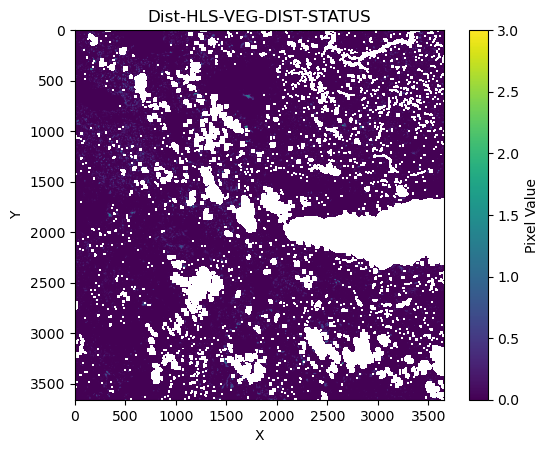

In [38]:
# Specify the path to the image file
# Define which dataset from dist-HLS to read using the sample list from above.
dist_hls_tile_number = 0
dist_hls_tile_dataset = 0

data_link = dist_data_df.iloc[dist_hls_tile_number].BandLinks[dist_hls_tile_dataset]
print(data_link)
dist_hls_dataset = data_link.split('v0_')[1].split('.tif')[0]

with rio.open(data_link, mode='r') as src:
    # Read the raster data
    raster_data = src.read()
    # Get the image metadata
    transform = src.transform
    crs = src.crs.to_string()
    print(transform, crs)

    # Visualize 
    plt.imshow(np.ma.masked_where(raster_data[0]==255, raster_data[0]), cmap='viridis')  # Display the first band, you can change the index if there are multiple bands
    plt.colorbar(label='Pixel Value')  # Add colorbar
    plt.title(f'Dist-HLS-{dist_hls_dataset}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()